In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.providers.aer import Aer
from qiskit.quantum_info import random_clifford
import random

In [2]:
n_qubits = 9
T = 4
qr = QuantumRegister(n_qubits, 'q')
cr = ClassicalRegister(n_qubits, 'c')
circ = QuantumCircuit(qr, cr)
p = 0.05

for t in range(T):
    for i in range(n_qubits // 2):
        circ.append(random_clifford(2), [qr[2*i], qr[2*i+1]])
    
    for i in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[i], cr[i])
    
    circ.save_state(pershot = True, label = "t"+str(2*t))

    for j in range((n_qubits - 1) // 2):
        circ.append(random_clifford(2), [qr[2*j+1], qr[2*j+2]])
    
    if n_qubits % 2 == 0:
        circ.append(random_clifford(2), [qr[-1], qr[0]])
    
    for j in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[j], cr[j])

    circ.save_state(pershot = True, label = "t"+str(2*t+1))

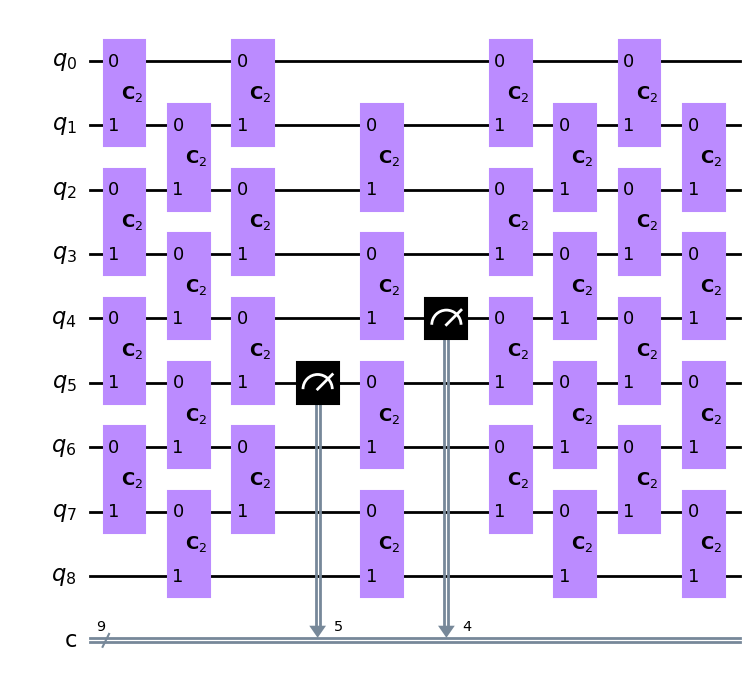

In [3]:
style = {
    'displaytext': {
        'clifford': r'\mathbf{C}_2'
    }
}

circ.draw('mpl', style = style, plot_barriers = False)

In [4]:
simulator = Aer.get_backend('aer_simulator_stabilizer')
circ = transpile(circ, simulator)

In [5]:
# circ.draw('mpl')

In [6]:
result = simulator.run(circ, shots = 10).result()

In [7]:
stabs = result.data()['t7']

In [8]:
test_stab = stabs[0]; test_stab

StabilizerState(StabilizerTable: ['-IIIIIIXZX', '-YIZIIYZXI', '+IIIIIIIXZ', '+ZYXZXYXZX', '+XYYYZIIII', '-XXZXXIYXI', '+XIXYYXXII', '-YZYYZXZXI', '+YIYIXIYXI'])

In [9]:
cliff = test_stab.clifford

In [10]:
import galois
import numpy as np

In [11]:
GF = galois.GF(2)

In [12]:
def B(G):
    rv = []
    for i in range(n_qubits): # loop through rows
        l = np.inf
        r = -np.inf
        for j in range(n_qubits): # loop through columns
            if G[i, 2*j] == 1 or G[i, 2*j+1] == 1:
                l = min(l, j)
                r = max(r, j)
        rv.append((l, r))
    return np.array(rv)

In [13]:
stab_2 = GF(cliff.stab.astype(int))[:, :-1]
# Convert from X|Z to xz...xz, and convert to standard order
stab = np.empty_like(stab_2)
stab[:, 0::2] = stab_2[:, n_qubits-1::-1]
stab[:, 1::2] = stab_2[:, :n_qubits-1:-1]

In [14]:
stab_rr = stab.row_reduce() # Pregauge

In [15]:
stab_rr

GF([[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]], order=2)

In [16]:
rev = stab_rr[::-1,::-1]
rev

GF([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]], order=2)

In [17]:
B(rev)

array([[0, 1],
       [0, 2],
       [0, 4],
       [0, 5],
       [0, 6],
       [0, 7],
       [0, 7],
       [3, 8],
       [0, 8]])

In [18]:
rowset = set()
for j in range(2 * n_qubits):
    col = rev[:, j]
    rows = np.nonzero(col)[0]
    if len(rows) == 0:
        continue
    if len(rows) == 1:
        rowset.add(rows[0])
        continue
    for i, row in enumerate(rows):
        if row not in rowset:
            rowset.add(row)
            if i != len(rows) - 1:
                rev[rows[i+1:],:] += rev[row,:]
rev

GF([[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]], order=2)

In [19]:
B(rev)

array([[0, 1],
       [0, 2],
       [2, 4],
       [1, 5],
       [3, 6],
       [3, 7],
       [3, 7],
       [3, 8],
       [3, 8]])